         gid  entidad          objeto                             fna     gna  \
0       1165        3  Espejo de agua                             NaN     NaN   
1        966        3  Espejo de agua                             NaN     NaN   
2      18116        3  Espejo de agua                             NaN     NaN   
3       1036        3  Espejo de agua                             NaN     NaN   
4      19193        3  Espejo de agua                             NaN     NaN   
...      ...      ...             ...                             ...     ...   
20684   5841        3  Espejo de agua  Laguna Mar Chiquita (Ansenuza)  Laguna   
20685   1161        3  Espejo de agua                             NaN     NaN   
20686   8941        3  Espejo de agua                             NaN     NaN   
20687   1162        3  Espejo de agua                             NaN     NaN   
20688   1929        3  Espejo de agua                             NaN     NaN   

                           

<Axes: >

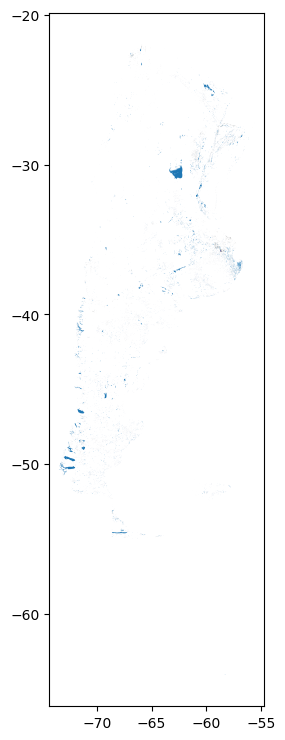

In [1]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import LineString
from shapely.geometry import Point
from shapely.geometry import Polygon
from pyproj import Geod
from pandas.core.common import flatten

#Copy your dataframe to "DataExamples" folder and replace the filepath from below
lakes = gpd.read_file("DataExamples/areas_de_aguas_continentales_perenne.geojson")
print(lakes)
lakes.plot(figsize=(9, 9))


In [2]:
class Gridifier:
    
    def __init__(self, geod):
        self.geod = Geod(ellps=geod)
    
    def gridify_segment(self, line, position, cell_wide, cells_total_high, number_of_rows):
        #Crea las celdas dentro de un segmento.

        #Para hacerlo:
        #Mide el largo en metros segun el geoide en el que se encuentra.
        #Paraleliza el segmento
        #Divide esa cantidad de metros segun el ancho de celda pasado por parametro.
        #Interpola (crea los puntos intermedios) de la linea original y de la linea paralela
        #segun el resultado de la division anterior.
        #Se crean lineas verticales apartir de cada punto interpolado
        #   .---.---.            .   .   .
        #                =====>  |   |   |
        #   .---.---.            .   .   .
        #Que a su vez la lineas verticales son interpoladas segun la cantidad de filas que se pasan
        #por parametro. Suponiendo dos filas. 
        #     .   .   .
        #     .   .   .
        #     .   .   .
        #(Notece que estan unidos de forma vertical y no horizontal)

        #Apartir de estos puntos de lineas verticales se crea la grilla de celdas
        #     .   .   .
        #     .___.   .
        #     |___|   .

        linelen = float(f"{self.geod.geometry_length(line):.3f}")
        number_of_divisions = (linelen // cell_wide) + 1


        parallel_segment = line.parallel_offset(self.meters_to_coords(cells_total_high), position, join_style=2)


        #Soluciona bug de parallel_offset que al crear la linea paralela del lado derecho 
        #   invierte el orden de los puntos             
        parallel_segment = self.fix_right_parallel(position, parallel_segment)
        
        interpolated_line = self.interpolate_line(number_of_divisions, line)
        interpolated_parallel = self.interpolate_line(number_of_divisions, parallel_segment)

        vertical_lines = self.create_interpolated_vertical_lines(interpolated_line, interpolated_parallel, number_of_rows)

        polygons = self.create_grid_from_vertical_lines(vertical_lines)

        return polygons
    
    def fix_right_parallel(self, position, parallel_line):
            #Soluciona bug de parallel_offset que al crear la linea paralela del lado derecho 
            #    invierte el orden de los puntos
        parallel = parallel_line
        if(position == "right"):
            parallel = list(parallel_line.coords)
            parallel.reverse()
            parallel = LineString(parallel)
        return parallel
    
    def create_grid_from_vertical_lines(self, vertical_lines):
        #Toma lineas verticales e itera sobre los puntos para crear celdas
        #Crea las celdas de abajo para arriba y de izquierda a derecha.
        num_col = len(vertical_lines) - 1
        num_row = len((vertical_lines[0].coords)) -1
        i_col = 0
        i_row = 0
        polygons = []
        while( (i_col + 1) <= num_col):
            while((i_row + 1) <= num_row ):
                polygon = Polygon([(vertical_lines[i_col].coords)[i_row], (vertical_lines[i_col + 1].coords)[i_row], 
                       (vertical_lines[i_col + 1].coords)[i_row + 1], (vertical_lines[i_col].coords)[i_row + 1],
                       (vertical_lines[i_col].coords)[i_row]])
                polygons.append(polygon)
                i_row = i_row + 1
            i_col = i_col + 1
            i_row = 0
        return polygons

    def create_interpolated_vertical_lines(self, line, parallel, number_of_divisions):
        #Toma las lineas paralelas y crea lineas verticales en los puntos interpolados previamente.
        #Interpola(divide) las lineas verticales segun la cantidad de filas de la grilla.
        vertical_lines = []
        i = 0
        while(i < len(line.coords)):
            vertical_line = LineString([(line.coords)[i], (parallel.coords)[i]])
            vertical_line_interpolated = self.interpolate_line(number_of_divisions ,vertical_line)
            vertical_lines.append(vertical_line_interpolated)
            i = i + 1
        return vertical_lines


    def interpolate_line(self, number_of_divisions, two_points_linestring):
        #Agrega puntos intermedios a una linea segun el parametro dado.
        i = 0
        interpolated_points = [Point(list(two_points_linestring.coords)[0])]
        while(i < number_of_divisions):
            dd = (i + 1) / number_of_divisions
            interpolated_points.append(two_points_linestring.interpolate(dd, normalized=True))
            i = i + 1
        return LineString(interpolated_points)
    
    def meters_to_coords(self, meters):
        #Transforma metros en coordenadas.
        #Toma un numero inicial, calcula la cantidad de metros que este numero genera. Y luego
        #Calcula el multiplicando que lleva al numero inicial a la cantidad de metros requeridos.
        variant = 0.0001
        tester = LineString([(0.0, 0.0), (variant, 0.0)])
        meters_distance = self.geod.geometry_length(tester)
        meters_of_variant = float(f"{meters_distance:.3f}") #redondiado a 3 decimales
        dif = meters / meters_of_variant 
        return (variant * dif)


class GridConector:
    
    def __init__(self, geod):
        self.gridify = Gridifier(geod)
        
        
    def create_cells_of_geom(self, geometry, position, cell_wide, cells_total_high, number_of_rows):
        #Crea las celdas

        #Checkea si la geometria del parametro es un poligono o multipoligono y lo convierte en linea
        if ((geometry.geom_type == 'MultiPolygon') | (geometry.geom_type == 'Polygon')):
            line = self.multi_polygon_to_line_string(geometry)
        else:
            line = self.multiLineString_to_LineString_each_row(geometry)


        i=0
        polygons = []
        #Itera sobre la linea
        while((i+2) < len(line.coords)):
            #Obtiene segmentos de a 2 puntos
            linestring_segment = LineString((line.coords)[i:(i+2)])


            #Crea las celdas del segmento
            polygons_segment = self.gridify.gridify_segment(linestring_segment, position, cell_wide, cells_total_high, number_of_rows)
            #Une los segmentos
            #polygons.append(polygons_segment) #error concavo convexo
            polygons = self.fix_append(polygons, polygons_segment, number_of_rows)

            i = i +1 
        geometry_polygons = list(flatten(polygons))

        #En el caso de los poligonos tambien hay que solucionar es desfasaje entre el primer segmento 
        #y el ultimo que tambien se conectan.
        if ((geometry.geom_type == 'MultiPolygon') | (geometry.geom_type == 'Polygon')):
            geometry_polygons = self.fix_last_and_first_point(geometry_polygons, number_of_rows)

        res = gpd.GeoDataFrame({"geometry" : geometry_polygons} )
        res['cid'] = res.index
        res['pos'] = position
        return res
    
    

    
    def fix_last_and_first_point(self, polygons, number_of_rows):
    #Arregla el desfasaje del ultimo y el primer punto
    #Tomo el numero de filas como parametro ya que es exactamente la cantidad de celdas
    #"conflictivas" que existen

        firsts = polygons[0:number_of_rows]
        lasts = polygons[(-number_of_rows):]
        fixed = self.fix_polygons(lasts, firsts)
        it = 0
        res = polygons
        #Modifica las celdas desfasadas con las arregladas
        for i in range(-number_of_rows,number_of_rows):
            res[i] = fixed[it]
            it = it + 1
        return(res)
        
    
    def fix_append(self, polygons, new_polygons, number_of_rows):
        #Arregla el desfasaje de las celdas ya creadas con respecto a un nuevo segmento a agregar
        #El numero de celdas es el indicativo exacto de cuantas filas hay que arreglar
        res_polygons = []

        if (polygons != []):
            total_len_polygons = len(polygons) 
            total_len_new_polygons = len(new_polygons) 

            #Selecciono y arreglo el desfasaje
            polygons_to_fix = polygons[(total_len_polygons-number_of_rows): total_len_polygons]
            new_polygons_to_fix = new_polygons[0:number_of_rows]
            fixed_polygons = self.fix_polygons(polygons_to_fix, new_polygons_to_fix)

            #Agrego a la lista de celdas completa
            res_polygons = polygons[0:(total_len_polygons-number_of_rows)]
            res_polygons.append(fixed_polygons)
            res_polygons.append(new_polygons[number_of_rows:total_len_new_polygons])
            res_polygons = list(flatten(res_polygons))
        else:
            res_polygons = new_polygons

        return(res_polygons)

    def fix_polygons(self, polygons, new_polygons):
        #Arregla el desfasaje entre dos segmentos de celdas
        #Toma los puntos de las celdas conflictivas y reemplaza los puntos desfasados con con el
        #centro entre ambos puntos
        polygon_it = 0
        fixed_polygons = []
        new_fixed_polygons = [] 
        for polygon in polygons:
            polygon_points = list(polygon.exterior.coords)
            new_polygon_points = list(new_polygons[polygon_it].exterior.coords)
            fst_point_to_replace = (LineString([polygon_points[1], new_polygon_points[0]])).centroid
            snd_point_to_replace = (LineString([polygon_points[2], new_polygon_points[3]])).centroid
            polygon_points[1] = fst_point_to_replace
            polygon_points[2] = snd_point_to_replace
            new_polygon_points[0] = fst_point_to_replace
            new_polygon_points[3] = snd_point_to_replace
            new_polygon_points[4] = fst_point_to_replace
            polygon_it = polygon_it + 1

            fixed_polygons.append(Polygon(polygon_points))
            new_fixed_polygons.append(Polygon(new_polygon_points))

        fixed_polygons.append(new_fixed_polygons)

        return(list(flatten(fixed_polygons)))

    


    def multiLineString_to_LineString_each_row(self, ob):
        #Transforma multilineas en lineas para trabajar con el mismo tipo de  objeto en todos los casos.
        linestrings = list(ob.geoms)
        coords = []
        for linestring in linestrings:
            coords.extend(linestring.coords)
        return LineString(coords)
    
    def multi_polygon_to_line_string(self, pol):
        #Transforma poligonos en lineas para trabajar con el mismo tipo de objeto en todos los casos.
        coord_list = list(list(pol.geoms)[0].exterior.coords)
        coord_list.append(coord_list[0])
        #coord_list.reverse()
        return LineString(coord_list)


    

    
class CoastlineGenerator(GridConector):
    
    def __init__(self, geod):
        super().__init__(geod)
        #Se inicializa un dataframe vacio con las columnas correspondientes al objeto de estudio creadas.
        self.coastlines = gpd.GeoDataFrame(columns=["geometry", 'cid', 'pos', 'gid', 'objeto', 'gna'])
        
    def export_to_geojson(self, file_name):
        #Exporta todo lo generado por este objeto.
        self.coastlines.to_file((file_name +'.geojson'), driver='GeoJSON')  
        
    def create_coastline_of_dataframe(self, aquifers, position, cell_wide, cells_total_high, number_of_rows):
        #Genera costas sobre todo un dataframe de geometrias.
        for aquifer in aquifers.itertuples(index=False):
            self.create_coastline_of_aquifer(aquifer, position, cell_wide, cells_total_high, number_of_rows)
    
    def create_coastline_cells(self, geometry, position, cell_wide, cells_total_high, number_of_rows):
        #Crea celdas cubriendo el caso de que sean creadas de ambos lados de una geometria.
        if(position == 'both'):
            rightSide = super().create_cells_of_geom(geometry ,'right' , cell_wide, cells_total_high, number_of_rows)
            leftSide = super().create_cells_of_geom(geometry ,'left' , cell_wide, cells_total_high, number_of_rows)
            cells = pd.concat([rightSide, leftSide])
        else:
            cells = super().create_cells_of_geom(geometry ,position , cell_wide, cells_total_high, number_of_rows)
        return cells
    
    
    def create_coastline_of_aquifer(self, aquifer, position, cell_wide, cells_total_high, number_of_rows):
    #Toma informacion del dataframe original y la agrega a cada celda generada
        geometry = aquifer.geometry
        gid = aquifer.gid
        objeto = aquifer.objeto
        gna = aquifer.gna

        ##Posibilidad de tomar distintos parametros para cada lado utilizando tuplas de parametros?.
        #Crea las celdas
        res = self.create_coastline_cells(geometry, position, cell_wide, cells_total_high, number_of_rows)

        res['gid'] = gid
        res['objeto'] = objeto
        res['gna'] = gna
        self.coastlines = pd.concat([self.coastlines, res])
        return res



In [3]:
#Check the readme to learn how to get the 'gid' of the specific geometry you need.
gutierrez = lakes.loc[lakes['gid'] == 33490]
gutierrez
#Use the number of the first column(index) as a parameter in the iloc down below. 

,gid,entidad,objeto,fna,gna,nam,sag,geometry
19918,33490,3,Espejo de agua,Lago Gutiérrez,Lago,Gutiérrez,IGN,"MULTIPOLYGON (((-71.38922 -41.17926, -71.38920..."


C:\Users\BrunoLattanzio\AppData\Local\Temp\ipykernel_7248\1982424519.py:291: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.coastlines = self.coastlines.append(res)


                                               geometry   cid   pos    gid  \
0     POLYGON ((-71.38922 -41.17926, -71.38921 -41.1...     0  left  33490   
1     POLYGON ((-71.38921 -41.17937, -71.38920 -41.1...     1  left  33490   
2     POLYGON ((-71.38920 -41.17949, -71.38922 -41.1...     2  left  33490   
3     POLYGON ((-71.38922 -41.17962, -71.38923 -41.1...     3  left  33490   
4     POLYGON ((-71.38923 -41.17975, -71.38920 -41.1...     4  left  33490   
...                                                 ...   ...   ...    ...   
1727  POLYGON ((-71.38944 -41.17841, -71.38937 -41.1...  1727  left  33490   
1728  POLYGON ((-71.38937 -41.17857, -71.38930 -41.1...  1728  left  33490   
1729  POLYGON ((-71.38930 -41.17873, -71.38927 -41.1...  1729  left  33490   
1730  POLYGON ((-71.38927 -41.17891, -71.38925 -41.1...  1730  left  33490   
1731  POLYGON ((-71.38925 -41.17908, -71.38922 -41.1...  1731  left  33490   

              objeto   gna  
0     Espejo de agua  Lago  
1    

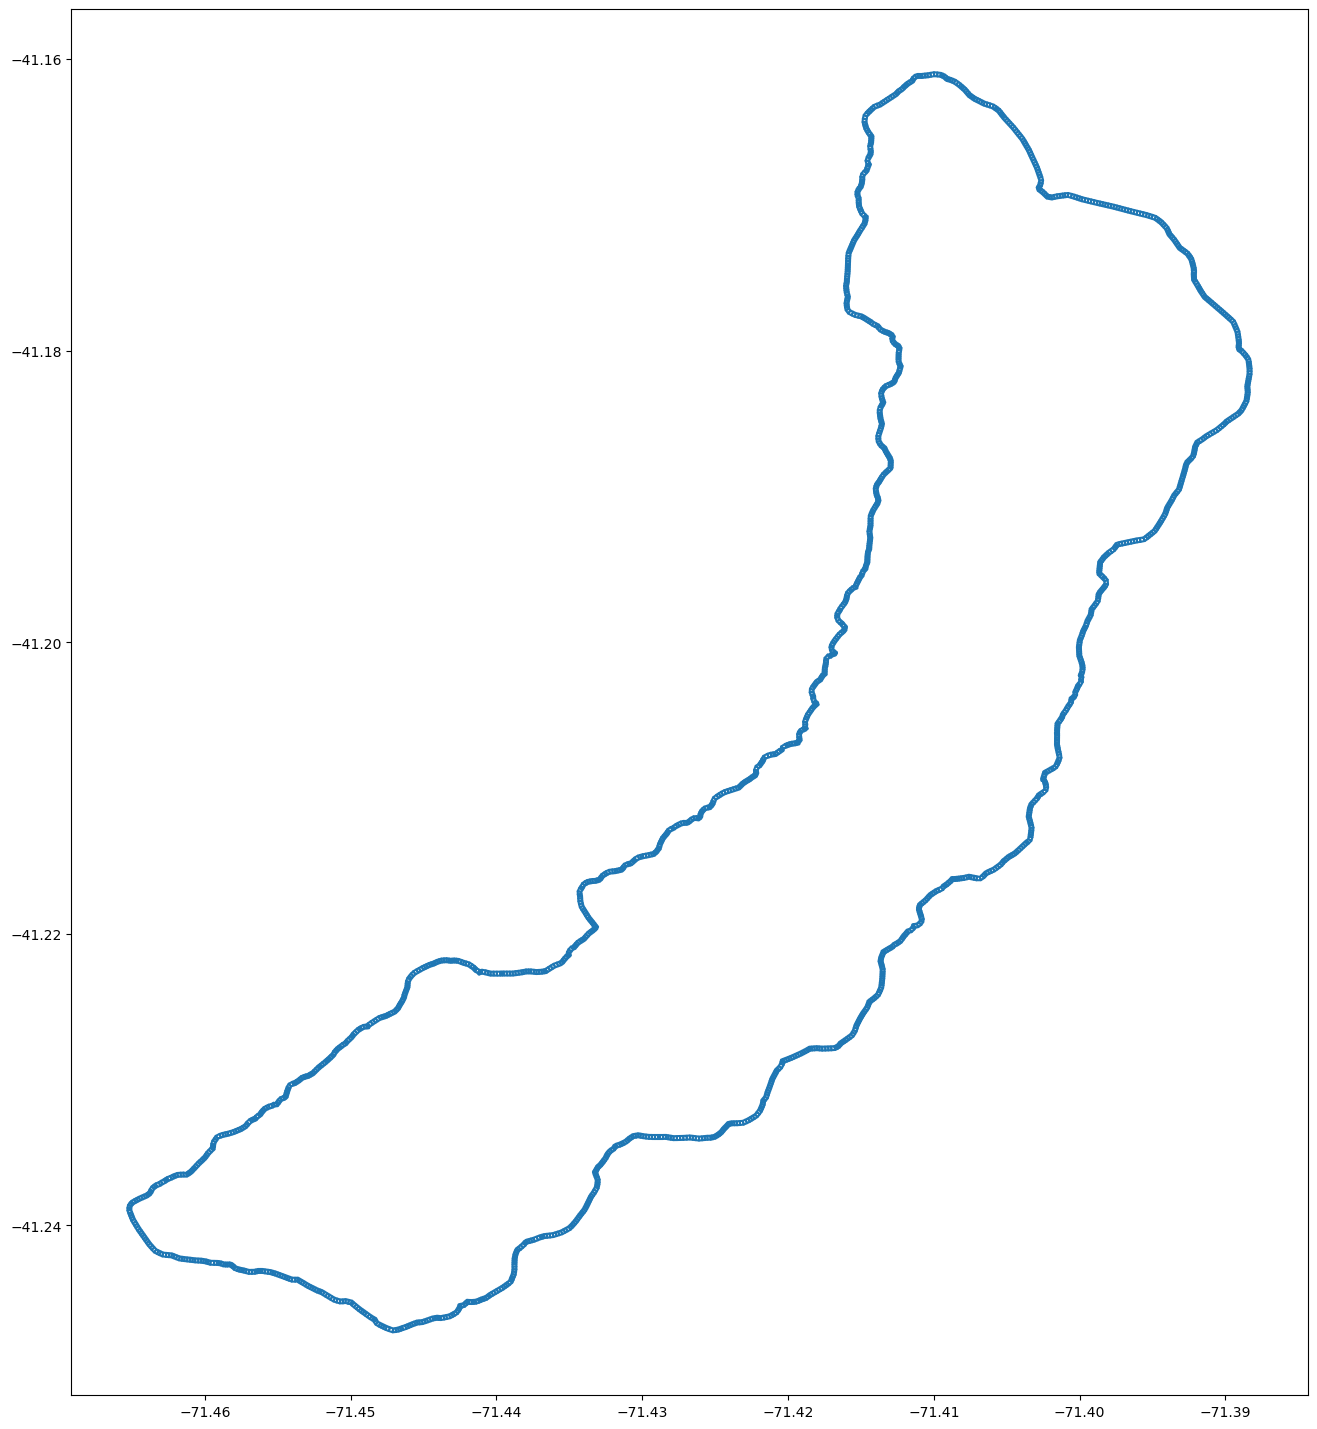

In [4]:
#Replace 'WGS84' with the map projection of the location of your dataset. 
#Change the parameters of 'create_coastline_of_aquifer' method to the ones you need. 
#The first parameter is the dataframe, the second is the position you want to make the teselation, 
#could be {right, left, both}, the third the wide of each cell, the fourth the height of the total 
#teselation in relation to the original line, and the last one is the number of divisions of that height.
#I encourage you to try different parameters.
acuifero = lakes.iloc[19918]
cg = CoastlineGenerator('WGS84')
coastline = cg.create_coastline_of_aquifer(acuifero, "left", 20, 30,1)
coastline.boundary.plot(figsize=(18, 18))
print(coastline)

In [6]:
#The exported data will be saved in the 'CoastlineGenerator' folder.
cg.export_to_geojson("lakes_coastline")